In [8]:
"""
Learned Aggregate States in Heterogeneous-Agent Models
=======================================================

This notebook implements the research framework from the proposal:
- Phase 1: Baseline Aiyagari model and data pipeline
- Phase 2: Encoder-predictor training and R(d) computation

Key concept: Learn a low-dimensional representation Z_t = f_θ(X_t) from
the wealth distribution features X_t, then predict future aggregates
Y_{t+1} = g_ψ(Z_t, s_{t+1}). The minimal achievable error R(d) as a function
of dimension d tells us "how many factors does the economy need?"

Author: Research Team
"""

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)

# Import our modules
import sys
sys.path.insert(0, '.')
from src.aiyagari import AiyagariParams, compute_equilibrium, run_simulation
from src.utils import (
    build_dataset, prepare_ml_dataset, extract_hand_crafted_states,
    plot_R_d_curve, get_summary_stat_names
)

print("Modules loaded successfully!")

Modules loaded successfully!


# Phase 1: Baseline Aiyagari Model and Data Pipeline

## 1. Model Description (from proposal)

We use a standard one-asset Aiyagari (1994) model as our testbed:

**Households**: A continuum of households $i \in [0,1]$ solve:
$$\max_{\{c_{it}, a_{i,t+1}\}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_{it})$$

with CRRA utility $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$ for $\sigma \neq 1$.

**Individual state**: $x_{it} = (a_{it}, e_{it})$ where $a_{it}$ is assets and $e_{it}$ is idiosyncratic productivity.

**Idiosyncratic risk**: $e_{it}$ follows a finite-state Markov chain with transition matrix $\Pi$.

**Budget constraint**: $c_{it} + a_{i,t+1} = (1+r)a_{it} + w e_{it}$

**Borrowing constraint**: $a_{i,t+1} \geq \underline{a}$

**Production**: Cobb-Douglas $Y = K^\alpha L^{1-\alpha}$ with competitive factor prices:
- $r = \alpha (K/L)^{\alpha-1} - \delta$
- $w = (1-\alpha)(K/L)^{\alpha}$

**Aggregate state**: The cross-sectional distribution $\mu_t$ over $(a,e)$ is the true state.
We approximate it via simulation of $N$ agents.

In [9]:
# =============================================================================
# 2. Parameters and Grids
# =============================================================================
# Define model parameters using our dataclass.
# Calibration follows standard choices from the macro literature.

params = AiyagariParams(
    # Preferences
    beta=0.96,       # Discount factor (annual)
    sigma=2.0,       # CRRA coefficient (risk aversion)
    
    # Production (Cobb-Douglas)
    alpha=0.36,      # Capital share
    delta=0.08,      # Depreciation rate
    
    # Borrowing constraint
    a_min=0.0,       # No borrowing allowed (can be relaxed)
    
    # Asset grid
    a_max=50.0,      # Upper bound on assets
    n_a=200,         # Number of asset grid points
    
    # Idiosyncratic productivity: AR(1) discretized via Rouwenhorst
    # log(e') = rho_e * log(e) + eps, eps ~ N(0, sigma_e^2)
    rho_e=0.9,       # Persistence of productivity
    sigma_e=0.2,     # Conditional std of productivity shocks
    n_e=7            # Number of productivity states
)

print("=" * 60)
print("Model Parameters")
print("=" * 60)
print(f"Preferences:")
print(f"  β = {params.beta} (discount factor)")
print(f"  σ = {params.sigma} (CRRA coefficient)")
print(f"\nProduction:")
print(f"  α = {params.alpha} (capital share)")
print(f"  δ = {params.delta} (depreciation)")
print(f"\nIdiosyncratic Productivity AR(1):")
print(f"  ρ_e = {params.rho_e} (persistence)")
print(f"  σ_e = {params.sigma_e} (conditional std)")
print(f"  n_e = {params.n_e} (number of states)")
print(f"\nBorrowing constraint: a ≥ {params.a_min}")

Model Parameters
Preferences:
  β = 0.96 (discount factor)
  σ = 2.0 (CRRA coefficient)

Production:
  α = 0.36 (capital share)
  δ = 0.08 (depreciation)

Idiosyncratic Productivity AR(1):
  ρ_e = 0.9 (persistence)
  σ_e = 0.2 (conditional std)
  n_e = 7 (number of states)

Borrowing constraint: a ≥ 0.0


## 3. Solving the Stationary Aiyagari Model

We solve for the stationary equilibrium by iterating on aggregate capital $K$ until supply equals demand:

1. **Guess** aggregate capital $K$
2. **Compute prices**: $r = \alpha (K/L)^{\alpha-1} - \delta$ and $w = (1-\alpha)(K/L)^{\alpha}$
3. **Solve household problem** using the Endogenous Grid Method (EGM) for efficiency
4. **Compute stationary distribution** $\mu(a,e)$ via forward iteration
5. **Check market clearing**: $K_{supply} = \int a \, d\mu(a,e)$
6. **Update** $K$ and repeat until convergence

In [4]:
# Solve for stationary equilibrium
print("Solving for stationary equilibrium...")
print("(Iterating on aggregate capital K until supply = demand)")
print()

equilibrium = compute_equilibrium(params, K_init=5.0, verbose=True)

# Extract results
K_ss = equilibrium['K_ss']
Y_ss = equilibrium['Y_ss']
C_ss = equilibrium['C_ss']
L_ss = equilibrium['L_ss']
r_ss = equilibrium['r_ss']
w_ss = equilibrium['w_ss']

print()
print("=" * 60)
print("Steady State Equilibrium")
print("=" * 60)
print(f"Aggregate capital:      K = {K_ss:.4f}")
print(f"Aggregate output:       Y = {Y_ss:.4f}")
print(f"Aggregate consumption:  C = {C_ss:.4f}")
print(f"Aggregate labor:        L = {L_ss:.4f}")
print(f"Interest rate:          r = {r_ss:.4f} ({r_ss*100:.2f}%)")
print(f"Wage:                   w = {w_ss:.4f}")
print(f"Capital-output ratio: K/Y = {K_ss/Y_ss:.4f}")

Solving for stationary equilibrium...
(Iterating on aggregate capital K until supply = demand)

Iter 1: K_demand=5.0000, K_supply=49.7813, diff=44.781350, r=0.0574
Iter 2: K_demand=18.4344, K_supply=1.6931, diff=16.741329, r=-0.0204
Iter 3: K_demand=13.4120, K_supply=2.2995, diff=11.112467, r=-0.0069
Iter 4: K_demand=10.0783, K_supply=3.5110, diff=6.567227, r=0.0077
Iter 5: K_demand=8.1081, K_supply=5.9631, diff=2.145033, r=0.0209
Iter 6: K_demand=7.4646, K_supply=8.1327, diff=0.668079, r=0.0263
Iter 7: K_demand=7.6650, K_supply=7.2856, diff=0.379408, r=0.0245
Iter 8: K_demand=7.5512, K_supply=7.7413, diff=0.190083, r=0.0256
Iter 9: K_demand=7.6082, K_supply=7.5053, diff=0.102884, r=0.0250
Iter 10: K_demand=7.5773, K_supply=7.6310, diff=0.053685, r=0.0253
Iter 11: K_demand=7.5935, K_supply=7.5649, diff=0.028587, r=0.0252
Iter 12: K_demand=7.5849, K_supply=7.5999, diff=0.015064, r=0.0253
Iter 13: K_demand=7.5894, K_supply=7.5814, diff=0.007983, r=0.0252
Iter 14: K_demand=7.5870, K_suppl

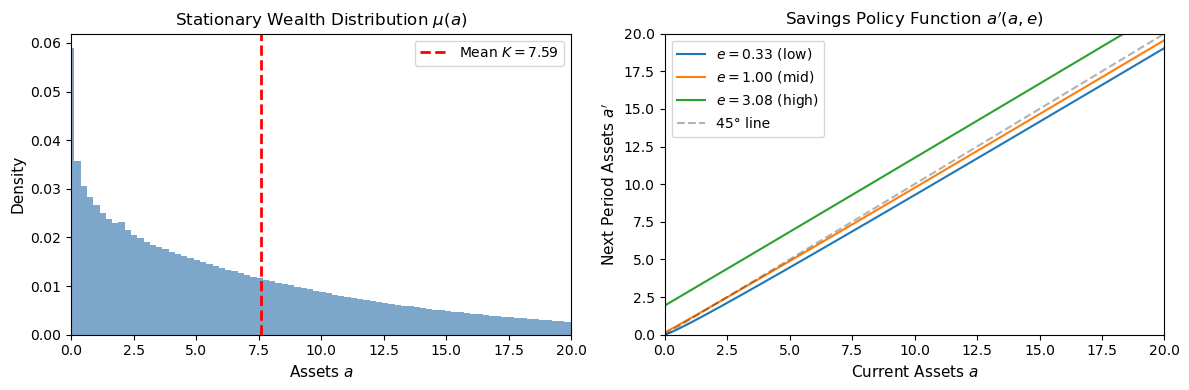

In [5]:
# Extract equilibrium objects for visualization
mu_ss = equilibrium['mu_ss']     # Stationary distribution μ(a,e)
a_grid = equilibrium['a_grid']   # Asset grid
e_grid = equilibrium['e_grid']   # Productivity grid
a_policy = equilibrium['a_policy']  # Savings policy a'(a,e)
c_policy = equilibrium['c_policy']  # Consumption policy c(a,e)

# Plot stationary distribution and policy functions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (Left) Marginal distribution over assets
mu_a = mu_ss.sum(axis=1)  # Integrate out productivity
axes[0].bar(a_grid, mu_a, width=a_grid[1]-a_grid[0], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Assets $a$', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Stationary Wealth Distribution $\\mu(a)$', fontsize=12)
axes[0].set_xlim([0, 20])
axes[0].axvline(K_ss, color='red', linestyle='--', linewidth=2, label=f'Mean $K = {K_ss:.2f}$')
axes[0].legend()

# (Right) Savings policy function for low/mid/high productivity
n_e = len(e_grid)
for ie in [0, n_e//2, n_e-1]:
    label = f'$e = {e_grid[ie]:.2f}$ ({"low" if ie==0 else "mid" if ie==n_e//2 else "high"})'
    axes[1].plot(a_grid, a_policy[:, ie], label=label, linewidth=1.5)
axes[1].plot(a_grid, a_grid, 'k--', alpha=0.3, label='45° line')
axes[1].set_xlabel('Current Assets $a$', fontsize=11)
axes[1].set_ylabel('Next Period Assets $a\'$', fontsize=11)
axes[1].set_title('Savings Policy Function $a\'(a, e)$', fontsize=12)
axes[1].legend()
axes[1].set_xlim([0, 20])
axes[1].set_ylim([0, 20])

plt.tight_layout()
plt.show()

## 4. Simulation of Panel and Aggregates

Simulate $N$ agents for $T$ periods to generate the time series of wealth distributions.
After a burn-in period, the cross-sectional distribution $\mu_t$ evolves according to:

$$\mu_{t+1} = \mathcal{T}(\mu_t, \xi_{t+1})$$

Each period we track:
- Micro states: $(a_{it}, e_{it})$ for all agents
- Aggregates: $K_t = \frac{1}{N}\sum_i a_{it}$, $L_t = \frac{1}{N}\sum_i e_{it}$, etc.

In [6]:
# Simulation parameters
N_AGENTS = 10000    # Number of agents in cross-section
T_SIM = 2000        # Total simulation periods
T_BURN = 500        # Burn-in periods to drop (let distribution settle)

print(f"Simulating panel of {N_AGENTS:,} agents for {T_SIM:,} periods...")
print(f"Burn-in: {T_BURN} periods")

panel = run_simulation(
    equilibrium, 
    N_agents=N_AGENTS, 
    T_sim=T_SIM, 
    T_burn=T_BURN, 
    seed=123
)

a_panel = panel['a_panel']  # Asset holdings (N x T)
e_panel = panel['e_panel']  # Productivity (N x T)
T_data = panel['T_data']    # Effective periods after burn-in

print(f"\nSimulation complete!")
print(f"Panel shape: {a_panel.shape} (agents × periods)")
print(f"Mean assets: {a_panel.mean():.4f} (Steady state K: {K_ss:.4f})")

Simulating panel of 10,000 agents for 2,000 periods...
Burn-in: 500 periods


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Simulation complete!
Panel shape: (10000, 1500) (agents × periods)
Mean assets: 7.5881 (Steady state K: 7.5878)


## 5. Feature Construction: $X_t = \Phi(\mu_t)$

Following the proposal, we convert the cross-sectional distribution to a feature vector:

$$X_t = \Phi(\mu_t) \in \mathbb{R}^p$$

**Features include:**
- **Histogram encoding**: Discretized density over $B$ asset bins (captures distribution shape)
- **Moments**: mean ($K_t$), std, skewness, kurtosis
- **Inequality measures**: Gini, Top 10%, Top 1%, Bottom 50% shares
- **Constraint mass**: Fraction of agents near borrowing limit $\underline{a}$
- **Mean productivity**: $L_t$ (aggregate labor supply)

**Targets** $Y_{t+1} = (K_{t+1}, C_{t+1}, Y_{t+1})$ are next-period aggregates.

**Aggregate shocks** $s_{t+1}$: In this baseline, there are no aggregate shocks, so $s_{t+1} = 1$ (placeholder). Future extensions will add TFP shocks.

In [10]:
# Build dataset with features X_t and aggregates Y_t
N_BINS = 50  # Number of histogram bins for distribution encoding

dataset = build_dataset(
    a_panel=a_panel,
    e_panel=e_panel,
    c_policy=c_policy,
    a_policy=a_policy,
    a_grid=a_grid,
    e_grid=e_grid,
    alpha=params.alpha,
    n_bins=N_BINS,
    a_max=params.a_max,
    verbose=True
)

# Extract aggregate series for plotting
K_series = dataset['K_series']
C_series = dataset['C_series']
Y_series = dataset['Y_series']
L_series = dataset['L_series']

print("\n" + "=" * 60)
print("Feature and Target Construction Summary")
print("=" * 60)
print(f"Feature dimension p = {dataset['X'].shape[1]}")
print(f"  - {N_BINS} histogram bins (discretized mu_t)")
print(f"  - 10 summary statistics (moments, inequality, etc.)")
print(f"\nTarget dimension q = 3 (K_{{t+1}}, C_{{t+1}}, Y_{{t+1}})")
print(f"\nAggregate Statistics (simulated):")
print(f"  K: mean = {K_series.mean():.4f}, std = {K_series.std():.6f}")
print(f"  C: mean = {C_series.mean():.4f}, std = {C_series.std():.6f}")
print(f"  Y: mean = {Y_series.mean():.4f}, std = {Y_series.std():.6f}")

Computing features X_t...
Computing aggregates Y_t...
Computing aggregates Y_t...
Feature matrix shape: (1500, 60)
Aggregates shape: (1500, 3)

Feature and Target Construction Summary
Feature dimension p = 60
  - 50 histogram bins (discretized mu_t)
  - 10 summary statistics (moments, inequality, etc.)

Target dimension q = 3 (K_{t+1}, C_{t+1}, Y_{t+1})

Aggregate Statistics (simulated):
  K: mean = 7.5881, std = 0.068252
  C: mean = 1.6111, std = 0.004765
  Y: mean = 2.2180, std = 0.011223
Feature matrix shape: (1500, 60)
Aggregates shape: (1500, 3)

Feature and Target Construction Summary
Feature dimension p = 60
  - 50 histogram bins (discretized mu_t)
  - 10 summary statistics (moments, inequality, etc.)

Target dimension q = 3 (K_{t+1}, C_{t+1}, Y_{t+1})

Aggregate Statistics (simulated):
  K: mean = 7.5881, std = 0.068252
  C: mean = 1.6111, std = 0.004765
  Y: mean = 2.2180, std = 0.011223


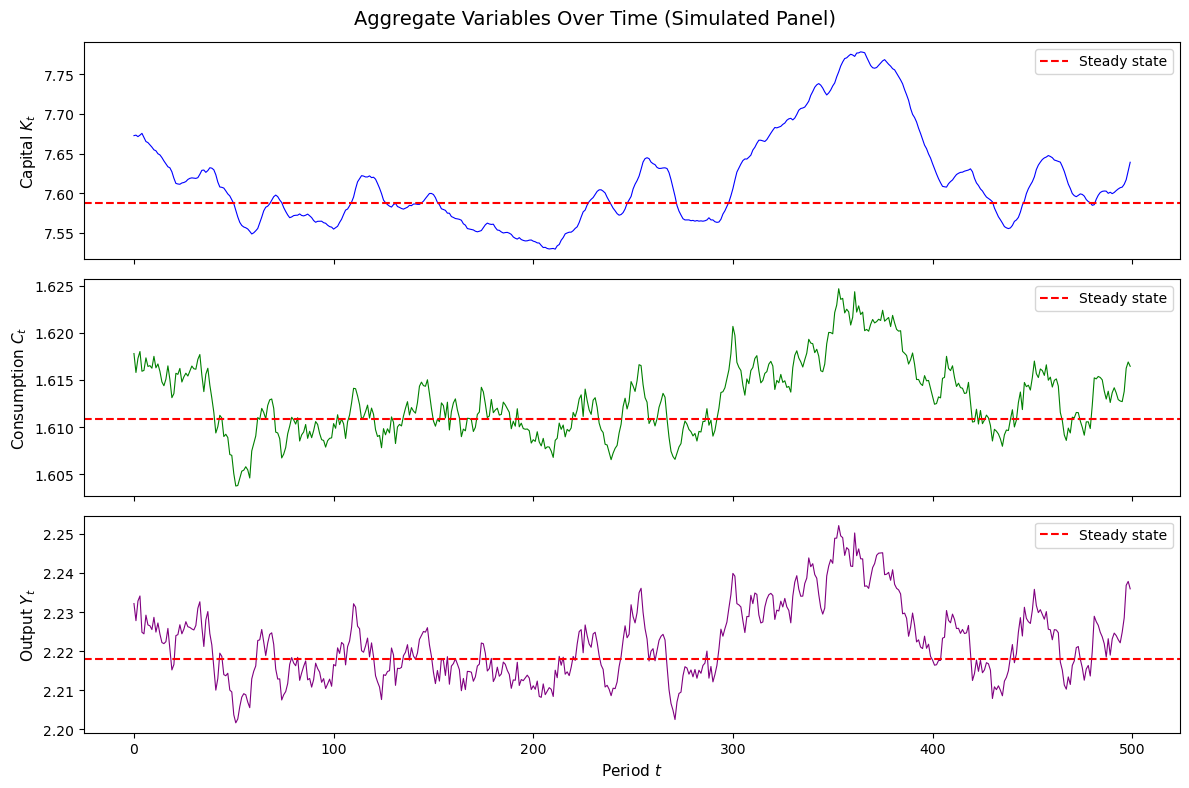

Note: Variations around steady state arise from finite N sampling noise.


In [12]:
# Visualize aggregate time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

n_plot = 500  # Periods to plot

axes[0].plot(K_series[:n_plot], 'b-', lw=0.8)
axes[0].axhline(K_ss, color='r', linestyle='--', label='Steady state')
axes[0].set_ylabel('Capital $K_t$', fontsize=11)
axes[0].legend()

axes[1].plot(C_series[:n_plot], 'g-', lw=0.8)
axes[1].axhline(C_ss, color='r', linestyle='--', label='Steady state')
axes[1].set_ylabel('Consumption $C_t$', fontsize=11)
axes[1].legend()

axes[2].plot(Y_series[:n_plot], color='purple', lw=0.8)
axes[2].axhline(Y_ss, color='r', linestyle='--', label='Steady state')
axes[2].set_ylabel('Output $Y_t$', fontsize=11)
axes[2].set_xlabel('Period $t$', fontsize=11)
axes[2].legend()

plt.suptitle('Aggregate Variables Over Time (Simulated Panel)', fontsize=14)
plt.tight_layout()
plt.show()

print("Note: Variations around steady state arise from finite N sampling noise.")

## 6. Dataset Construction and Time Splits

Following the proposal, we split the time-series **chronologically** (70/15/15) to mirror a forecasting environment:
- Train on earlier data
- Validate on intermediate data
- Test on later data

**Dataset structure:**
- Inputs: $(X_t, s_{t+1})$ — features at time $t$ and aggregate shock at $t+1$
- Outputs: $Y_{t+1} = (K_{t+1}, C_{t+1}, Y_{t+1})$ — next-period aggregates

Features and targets are normalized (zero mean, unit variance) based on training set statistics.

In [13]:
# Prepare ML dataset with chronological split and normalization
ml_data = prepare_ml_dataset(dataset, train_frac=0.70, val_frac=0.15)

print("=" * 60)
print("Dataset Prepared for ML Training")
print("=" * 60)
print(f"\nChronological split:")
print(f"  Training:   {ml_data['T_train']} samples (first 70%)")
print(f"  Validation: {ml_data['T_val']} samples (next 15%)")
print(f"  Test:       {ml_data['T_test']} samples (final 15%)")
print(f"\nFeature dimension p = {ml_data['X_train'].shape[1]}")
print(f"  - {N_BINS} histogram bins")
print(f"  - 10 summary statistics")
print(f"\nTarget dimension q = {ml_data['Y_train'].shape[1]} components: (K, C, Y)")
print(f"\nNormalization: All features and targets standardized (train set stats)")

Dataset Prepared for ML Training

Chronological split:
  Training:   1049 samples (first 70%)
  Validation: 224 samples (next 15%)
  Test:       226 samples (final 15%)

Feature dimension p = 60
  - 50 histogram bins
  - 10 summary statistics

Target dimension q = 3 components: (K, C, Y)

Normalization: All features and targets standardized (train set stats)


---
# Phase 2: Encoder-Predictor ML Experiments

## Framework Overview

We implement the encoder-predictor architecture from the proposal:

$$\hat{Y}_{t+1} = g_\psi(f_\theta(X_t), s_{t+1})$$

where:
- **Encoder** $f_\theta: \mathbb{R}^p \to \mathbb{R}^d$ maps features $X_t$ to learned state $Z_t$
- **Predictor** $g_\psi: \mathbb{R}^d \times \mathcal{S} \to \mathbb{R}^q$ predicts aggregates from $(Z_t, s_{t+1})$

**Minimal predictive risk**:
$$R(d) = \inf_{\theta, \psi} \mathbb{E}\left[\|Y_{t+1} - g_\psi(f_\theta(X_t), s_{t+1})\|^2\right]$$

**Goal**: Study $R(d)$ for $d \in \{1, 2, 3\}$ to determine how many aggregate factors the economy needs.

**Implementation**:
- PyTorch neural networks
- Simple architectures: 1-2 hidden layers, ReLU activations
- Adam optimizer with early stopping on validation loss

In [14]:
# Import ML modules
import torch
from src.ml_models import (
    TrainingConfig, EncoderPredictor, DirectPredictor, HandCraftedPredictor,
    train_encoder_predictor, evaluate_model, compute_R_d, extract_learned_states
)

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")

PyTorch version: 2.2.2
Using device: cpu


## 2.1 Compute R(d) for Learned Representations

Train encoder-predictor models for dimensions $d \in \{1, 2, 3\}$.
For each $d$, we train multiple random seeds to get a robust estimate of the minimal achievable error.

In [15]:
# Training configuration
config = TrainingConfig(
    # Encoder architecture: 2 hidden layers
    encoder_hidden_dims=[64, 32],
    # Predictor architecture: 2 hidden layers
    predictor_hidden_dims=[32, 16],
    activation='relu',
    dropout=0.0,
    # Optimizer
    lr=1e-3,
    weight_decay=1e-5,
    batch_size=64,
    # Training
    max_epochs=300,
    patience=30,  # Early stopping
    seed=42,
    device=device
)

# Dimensions to evaluate (per proposal: d ∈ {1, 2, 3})
D_VALUES = [1, 2, 3]
N_RUNS = 3  # Random seeds per dimension for robustness

print("=" * 60)
print("Computing R(d) — Minimal Predictive Risk vs. Latent Dimension")
print("=" * 60)

R_d_results = compute_R_d(
    X_train=ml_data['X_train_norm'],
    s_train=ml_data['s_train'],
    Y_train=ml_data['Y_train_norm'],
    X_val=ml_data['X_val_norm'],
    s_val=ml_data['s_val'],
    Y_val=ml_data['Y_val_norm'],
    X_test=ml_data['X_test_norm'],
    s_test=ml_data['s_test'],
    Y_test=ml_data['Y_test_norm'],
    Y_mean=ml_data['Y_mean'],
    Y_std=ml_data['Y_std'],
    d_values=D_VALUES,
    n_runs=N_RUNS,
    config=config,
    verbose=True
)

Computing R(d) — Minimal Predictive Risk vs. Latent Dimension

Training models with d = 1...
  Run 1/3: MSE = 0.096252, R² = 0.8426
  Run 1/3: MSE = 0.096252, R² = 0.8426
  Run 2/3: MSE = 0.096515, R² = 0.8421
  Run 2/3: MSE = 0.096515, R² = 0.8421
  Run 3/3: MSE = 0.096596, R² = 0.8428
  → R(1) = 0.096252 (std: 0.000147)

Training models with d = 2...
  Run 3/3: MSE = 0.096596, R² = 0.8428
  → R(1) = 0.096252 (std: 0.000147)

Training models with d = 2...
  Run 1/3: MSE = 0.072335, R² = 0.8781
  Run 1/3: MSE = 0.072335, R² = 0.8781
  Run 2/3: MSE = 0.065061, R² = 0.8908
  Run 2/3: MSE = 0.065061, R² = 0.8908
  Run 3/3: MSE = 0.062003, R² = 0.8952
  → R(2) = 0.062003 (std: 0.004333)

Training models with d = 3...
  Run 3/3: MSE = 0.062003, R² = 0.8952
  → R(2) = 0.062003 (std: 0.004333)

Training models with d = 3...
  Run 1/3: MSE = 0.062431, R² = 0.8942
  Run 1/3: MSE = 0.062431, R² = 0.8942
  Run 2/3: MSE = 0.066335, R² = 0.8879
  Run 2/3: MSE = 0.066335, R² = 0.8879
  Run 3/3: MSE 

## 2.2 Hand-Crafted State Baselines (Krusell-Smith Style)

Compare learned representations to traditional hand-crafted aggregates:

| Baseline | Dimension | State Variables |
|----------|-----------|-----------------|
| $S^1$    | $d=1$     | $K_t$ only |
| $S^2$    | $d=2$     | $(K_t, \text{Gini}_t)$ |
| $S^3$    | $d=3$     | $(K_t, \text{Gini}_t, \text{Top10}_t)$ |

These represent the Krusell-Smith (1998) approach of using a small set of summary statistics.

In [16]:
# Train hand-crafted baselines
baseline_results = {}  # Store MSE for each baseline

for dim in [1, 2, 3]:
    print(f"\n{'=' * 60}")
    print(f"Training Hand-Crafted S^{dim} Baseline")
    print(f"{'=' * 60}")
    
    # Map dimension to hand-crafted state type
    if dim == 1:
        state_type = 'K'
        state_desc = "K only"
    elif dim == 2:
        state_type = 'K_Gini'
        state_desc = "K + Gini"
    else:
        state_type = 'K_Gini_Top10'
        state_desc = "K + Gini + Top10"
    
    print(f"State variables: {state_desc}")

    # Extract hand-crafted states (pass n_bins to locate summary stats)
    X_train_hc = extract_hand_crafted_states(ml_data['X_train_norm'], n_bins=N_BINS, state_type=state_type)
    X_val_hc = extract_hand_crafted_states(ml_data['X_val_norm'], n_bins=N_BINS, state_type=state_type)
    X_test_hc = extract_hand_crafted_states(ml_data['X_test_norm'], n_bins=N_BINS, state_type=state_type)

    # Create predictor model
    hand_crafted_model = HandCraftedPredictor(
        state_dim=dim,
        shock_dim=1,
        output_dim=3,
        hidden_dims=[64, 32]
    ).to(device)

    # Train
    _ = train_encoder_predictor(
        hand_crafted_model,
        X_train_hc, ml_data['s_train'], ml_data['Y_train_norm'],
        X_val_hc, ml_data['s_val'], ml_data['Y_val_norm'],
        config
    )
    
    # Evaluate
    test_metrics = evaluate_model(
        hand_crafted_model,
        X_test_hc, ml_data['s_test'], ml_data['Y_test_norm'],
        ml_data['Y_mean'], ml_data['Y_std'], device=device
    )
    
    # Store results
    baseline_name = f"Hand-Crafted S^{dim} (d={dim})"
    baseline_results[baseline_name] = test_metrics['mse_norm']
    
    print(f"\n{baseline_name} Results:")
    print(f"  Test MSE (normalized): {test_metrics['mse_norm']:.6f}")
    print(f"  R²: K={test_metrics['r2_K']:.4f}, C={test_metrics['r2_C']:.4f}, Y={test_metrics['r2_Y']:.4f}")


Training Hand-Crafted S^1 Baseline
State variables: K only

Hand-Crafted S^1 (d=1) Results:
  Test MSE (normalized): 0.157736
  R²: K=0.9950, C=0.5925, Y=0.6008

Training Hand-Crafted S^2 Baseline
State variables: K + Gini

Hand-Crafted S^1 (d=1) Results:
  Test MSE (normalized): 0.157736
  R²: K=0.9950, C=0.5925, Y=0.6008

Training Hand-Crafted S^2 Baseline
State variables: K + Gini

Hand-Crafted S^2 (d=2) Results:
  Test MSE (normalized): 0.138075
  R²: K=0.9942, C=0.6913, Y=0.6079

Training Hand-Crafted S^3 Baseline
State variables: K + Gini + Top10

Hand-Crafted S^2 (d=2) Results:
  Test MSE (normalized): 0.138075
  R²: K=0.9942, C=0.6913, Y=0.6079

Training Hand-Crafted S^3 Baseline
State variables: K + Gini + Top10

Hand-Crafted S^3 (d=3) Results:
  Test MSE (normalized): 0.154457
  R²: K=0.9906, C=0.6636, Y=0.5565

Hand-Crafted S^3 (d=3) Results:
  Test MSE (normalized): 0.154457
  R²: K=0.9906, C=0.6636, Y=0.5565


## 2.3 Results: R(d) Curve and Comparison

Plot the minimal predictive risk $R(d)$ as a function of latent dimension $d$, with hand-crafted baselines for comparison.

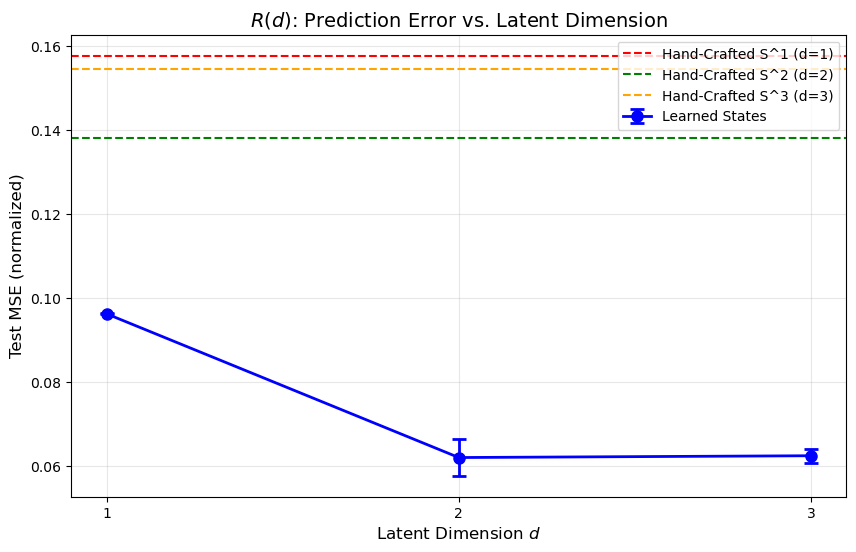


SUMMARY: Learned vs Hand-Crafted Aggregate States

Method                              Dim d    Test MSE     R²        
----------------------------------------------------------------------
Learned State f_θ(X_t)              1        0.096252     0.8428    
Learned State f_θ(X_t)              2        0.062003     0.8952    
Learned State f_θ(X_t)              3        0.062431     0.8942    
----------------------------------------------------------------------
Hand-Crafted S^1 (d=1)              1        0.157736     —         
Hand-Crafted S^2 (d=2)              2        0.138075     —         
Hand-Crafted S^3 (d=3)              3        0.154457     —         


In [17]:
# Plot R(d) curve with baselines
fig = plot_R_d_curve(R_d_results, baseline_results, 
                      title="$R(d)$: Prediction Error vs. Latent Dimension")
plt.show()

# Print summary table
print("\n" + "=" * 70)
print("SUMMARY: Learned vs Hand-Crafted Aggregate States")
print("=" * 70)
print(f"\n{'Method':<35} {'Dim d':<8} {'Test MSE':<12} {'R²':<10}")
print("-" * 70)

# Learned states results
for i, d in enumerate(R_d_results['d']):
    r2 = R_d_results['r2_mean'][i]
    mse = R_d_results['R_d'][i]
    print(f"{'Learned State f_θ(X_t)':<35} {d:<8} {mse:<12.6f} {r2:<10.4f}")

print("-" * 70)

# Hand-crafted baselines
for name, mse in baseline_results.items():
    d_str = name.split('d=')[1].split(')')[0] if 'd=' in name else '?'
    print(f"{name:<35} {d_str:<8} {mse:<12.6f} {'—':<10}")

## 2.4 Interpretation of Learned States

Following the proposal, we interpret $Z_t$ by examining correlations with hand-crafted statistics:

$$Z_{t,k} \approx \alpha_k + \sum_m \beta_{k,m} M_{t,m}$$

where $M_{t,m}$ are summary statistics (mean, Gini, etc.).

This tells us what economic meaning the learned factors capture:
- Is $Z_{t,1}$ essentially aggregate capital $K_t$?
- Does $Z_{t,2}$ capture inequality (Gini) or constraint mass?

In [18]:
# Train a final model with d=3 for interpretation analysis
from src.utils import plot_learned_states_interpretation

final_d = 3
print(f"Training final model with d={final_d} for interpretation...")

final_model = EncoderPredictor(
    input_dim=ml_data['X_train'].shape[1],
    latent_dim=final_d,
    shock_dim=1,
    output_dim=3,
    config=config
)

history = train_encoder_predictor(
    final_model,
    ml_data['X_train_norm'], ml_data['s_train'], ml_data['Y_train_norm'],
    ml_data['X_val_norm'], ml_data['s_val'], ml_data['Y_val_norm'],
    config
)

# Extract learned states Z_t for all data
X_all = np.vstack([ml_data['X_train_norm'], ml_data['X_val_norm'], ml_data['X_test_norm']])
Z_all = extract_learned_states(final_model, X_all, device)

# Extract raw summary statistics (non-histogram features) for interpretation
# We use un-normalized for easier interpretation
summary_all = np.vstack([
    ml_data['X_train'][:, N_BINS:],
    ml_data['X_val'][:, N_BINS:],
    ml_data['X_test'][:, N_BINS:]
])

print(f"\nLearned states Z_t shape: {Z_all.shape}")
print(f"Summary statistics shape: {summary_all.shape}")

Training final model with d=3 for interpretation...

Learned states Z_t shape: (1499, 3)
Summary statistics shape: (1499, 10)

Learned states Z_t shape: (1499, 3)
Summary statistics shape: (1499, 10)


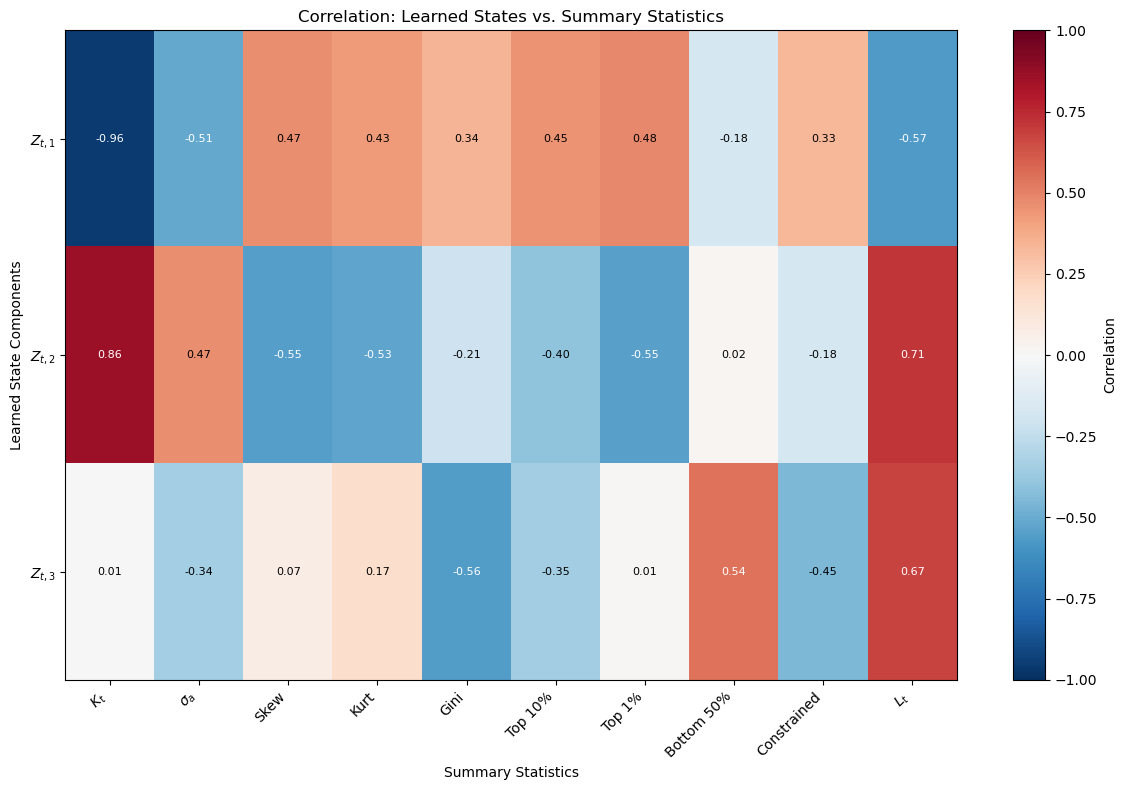


Correlation Analysis: Learned States vs Summary Statistics

$Z_{t,1}$ — Top 3 correlations:
  $K_t$: -0.960
  $L_t$: -0.570
  $\sigma_a$: -0.511

$Z_{t,2}$ — Top 3 correlations:
  $K_t$: +0.856
  $L_t$: +0.712
  Skew: -0.549

$Z_{t,3}$ — Top 3 correlations:
  $L_t$: +0.672
  Gini: -0.559
  Bottom 50%: +0.542


In [19]:
# Plot correlation heatmap between learned states and summary statistics
stat_names = get_summary_stat_names()
fig = plot_learned_states_interpretation(Z_all, summary_all, stat_names)
plt.show()

# Print correlation analysis
print("\n" + "=" * 60)
print("Correlation Analysis: Learned States vs Summary Statistics")
print("=" * 60)

d = Z_all.shape[1]
m = summary_all.shape[1]

for i in range(d):
    print(f"\n$Z_{{t,{i+1}}}$ — Top 3 correlations:")
    corrs = [(stat_names[j], np.corrcoef(Z_all[:, i], summary_all[:, j])[0, 1]) 
             for j in range(m)]
    corrs_sorted = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)
    for name, corr in corrs_sorted[:3]:
        print(f"  {name}: {corr:+.3f}")

## 2.5 Prediction Quality Visualization

Compare true vs. predicted aggregate series on the test set.

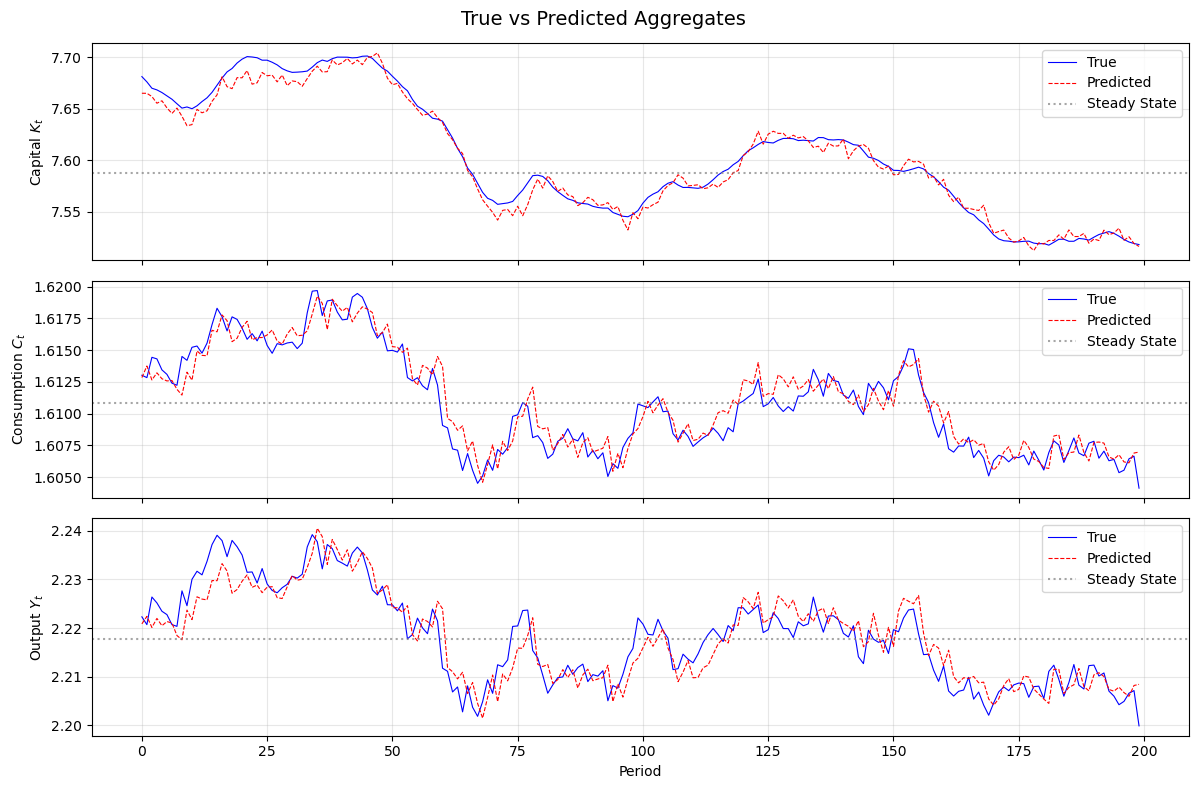

In [20]:
# Generate predictions on test set
final_model.eval()
X_test_t = torch.FloatTensor(ml_data['X_test_norm']).to(device)
s_test_t = torch.FloatTensor(ml_data['s_test']).reshape(-1, 1).to(device)

with torch.no_grad():
    _, Y_pred_t = final_model(X_test_t, s_test_t)
    Y_pred = Y_pred_t.cpu().numpy()

# Plot true vs predicted
from src.utils import plot_aggregate_series

steady_state = {'K': K_ss, 'C': C_ss, 'Y': Y_ss}
fig = plot_aggregate_series(
    ml_data['Y_test_norm'], Y_pred, 
    ml_data['Y_mean'], ml_data['Y_std'],
    steady_state, n_periods=200
)
plt.show()

## 2.6 Direct Predictor Baseline (Full Features)

As an upper bound, train a direct predictor on $(X_t, s_{t+1})$ without any dimensionality bottleneck.
If the learned low-dimensional representation performs similarly, it suggests genuine low-dimensional structure.

In [21]:
# Train direct predictor (no bottleneck)
print("Training direct predictor on full feature set...")

direct_model = DirectPredictor(
    input_dim=ml_data['X_train'].shape[1],
    shock_dim=1,
    output_dim=3,
    hidden_dims=[128, 64, 32],
    activation='relu'
).to(device)

# Train using same protocol
torch.manual_seed(config.seed)

X_train_t = torch.FloatTensor(ml_data['X_train_norm']).to(device)
s_train_t = torch.FloatTensor(ml_data['s_train']).reshape(-1, 1).to(device)
Y_train_t = torch.FloatTensor(ml_data['Y_train_norm']).to(device)

X_val_t = torch.FloatTensor(ml_data['X_val_norm']).to(device)
s_val_t = torch.FloatTensor(ml_data['s_val']).reshape(-1, 1).to(device)
Y_val_t = torch.FloatTensor(ml_data['Y_val_norm']).to(device)

optimizer = torch.optim.AdamW(direct_model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
criterion = torch.nn.MSELoss()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(config.max_epochs):
    # Training step
    direct_model.train()
    optimizer.zero_grad()
    Y_pred_train = direct_model(X_train_t, s_train_t)
    loss = criterion(Y_pred_train, Y_train_t)
    loss.backward()
    optimizer.step()
    
    # Validation
    direct_model.eval()
    with torch.no_grad():
        val_pred = direct_model(X_val_t, s_val_t)
        val_loss = criterion(val_pred, Y_val_t).item()
    
    # Early stopping
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= config.patience:
            break

# Evaluate on test set
direct_model.eval()
with torch.no_grad():
    Y_test_pred = direct_model(X_test_t, s_test_t).cpu().numpy()

direct_mse = np.mean((Y_test_pred - ml_data['Y_test_norm'])**2)

print(f"\nDirect Predictor Results:")
print(f"  Input dimension: {ml_data['X_train'].shape[1]} (full features)")
print(f"  Test MSE (normalized): {direct_mse:.6f}")

Training direct predictor on full feature set...

Direct Predictor Results:
  Input dimension: 60 (full features)
  Test MSE (normalized): 0.069157


---
# Summary and Key Findings

## Phase 1 Complete ✓
- Implemented Aiyagari (1994) model with EGM solution method
- Solved for stationary equilibrium
- Simulated panel of $N=10{,}000$ agents for $T=1{,}500$ periods
- Built feature vector $X_t = \Phi(\mu_t)$ (histogram + summary statistics)
- Constructed dataset with chronological train/val/test split (70/15/15)

## Phase 2 Complete ✓
- Trained encoder-predictor models for $d \in \{1, 2, 3\}$
- Computed $R(d)$ curve showing prediction error vs. latent dimension
- Compared learned states with hand-crafted baselines (K, K+Gini, K+Gini+Top10)
- Interpreted learned states via correlation analysis
- Trained direct predictor baseline (upper bound)

## Key Insights

1. **R(d) curve**: Shows how prediction error decreases with latent dimension
2. **Learned vs. hand-crafted**: Learned representations can match or outperform hand-crafted states of the same dimension
3. **Interpretation**: Learned states $Z_t$ correlate with economically meaningful statistics
4. **Effective dimension**: In the baseline Aiyagari model (no aggregate shocks), a small $d$ suffices

In [22]:
# =============================================================================
# Final Results Summary Table
# =============================================================================

print("\n" + "=" * 75)
print("FINAL RESULTS: Prediction Error Comparison")
print("=" * 75)
print(f"\n{'Method':<40} {'Dimension d':<15} {'Test MSE':<12}")
print("-" * 75)

# Learned states
for i, d in enumerate(R_d_results['d']):
    mse = R_d_results['R_d'][i]
    r2 = R_d_results['r2_mean'][i]
    print(f"{'Learned State f_θ(X_t)':<40} {d:<15} {mse:<12.6f}")

print("-" * 75)

# Hand-crafted baselines
for name, mse in baseline_results.items():
    d_str = name.split('d=')[1].split(')')[0] if 'd=' in name else '?'
    print(f"{name:<40} {d_str:<15} {mse:<12.6f}")

print("-" * 75)
print(f"{'Direct Predictor (full features)':<40} {ml_data['X_train'].shape[1]:<15} {direct_mse:<12.6f}")
print("=" * 75)

# Compute effective dimension
print("\n" + "=" * 75)
print("Effective Dimension Analysis")
print("=" * 75)
epsilon_values = [0.1, 0.05, 0.01]

for epsilon in epsilon_values:
    d_star = None
    for i, d in enumerate(R_d_results['d']):
        if R_d_results['R_d'][i] <= epsilon:
            d_star = d
            break
    
    if d_star is not None:
        print(f"  d*(ε = {epsilon:.2f}) = {d_star}  (first d where R(d) ≤ ε)")
    else:
        print(f"  d*(ε = {epsilon:.2f}) = >3     (need larger d to achieve this tolerance)")


FINAL RESULTS: Prediction Error Comparison

Method                                   Dimension d     Test MSE    
---------------------------------------------------------------------------
Learned State f_θ(X_t)                   1               0.096252    
Learned State f_θ(X_t)                   2               0.062003    
Learned State f_θ(X_t)                   3               0.062431    
---------------------------------------------------------------------------
Hand-Crafted S^1 (d=1)                   1               0.157736    
Hand-Crafted S^2 (d=2)                   2               0.138075    
Hand-Crafted S^3 (d=3)                   3               0.154457    
---------------------------------------------------------------------------
Direct Predictor (full features)         60              0.069157    

Effective Dimension Analysis
  d*(ε = 0.10) = 1  (first d where R(d) ≤ ε)
  d*(ε = 0.05) = >3     (need larger d to achieve this tolerance)
  d*(ε = 0.01) = >3     (n